The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


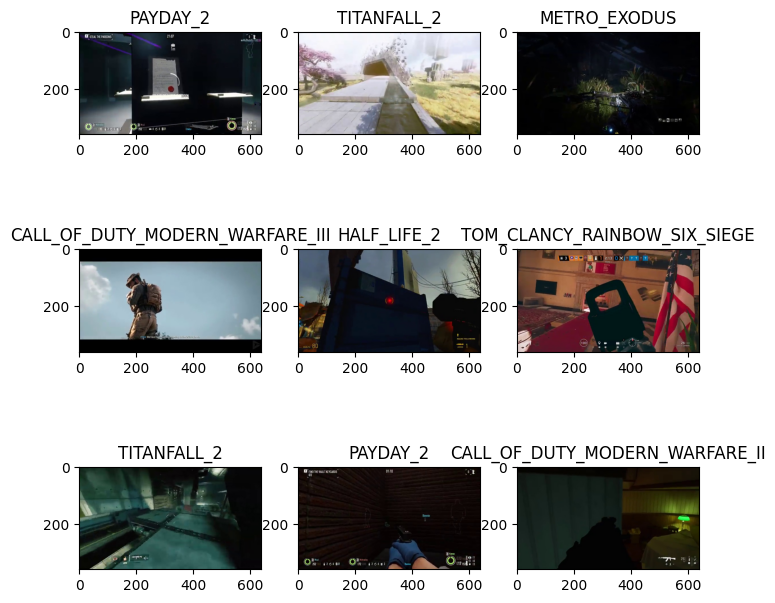

In [10]:
from datareader.dataset import GameScreenShotDataset
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision.datasets import ImageFolder

# autoreload
%load_ext autoreload
%autoreload 2

transform = transforms.Compose([
    transforms.Resize((360, 640)),
    transforms.ToTensor()
])

dataset_folder = './dataset/processed'

batch_size = 16
train_dataset = GameScreenShotDataset(root=os.path.join(dataset_folder, 'train'), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset = GameScreenShotDataset(root=os.path.join(dataset_folder, 'val'), transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
test_dataset = GameScreenShotDataset(root=os.path.join(dataset_folder, 'test'), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.imshow(img.numpy().transpose(1,2,0))
plt.show()


In [8]:
# Try folder dataset
test_dataset = ImageFolder(root=os.path.join(dataset_folder, 'test'), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

# first data
data_iter = iter(test_dataloader)
images, labels = next(data_iter)
print(images.shape, labels.shape)
print(labels)

torch.Size([16, 3, 360, 640]) torch.Size([16])
tensor([20, 29,  3, 12, 29, 25, 14, 10,  7, 26, 28, 23, 26, 11, 12, 10])


In [2]:
from torchvision.models import resnet18, ResNet18_Weights, inception_v3, vit_b_16
from torch import nn
from tqdm import tqdm


# Training script
def train_model(model, dataloader, loss_fn, optimizer, epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    for i in range(0, epochs):
        model.train()
        
        running_loss = 0.0
        epoch_loss = 0.0
        
        # Train
        for i, batch in tqdm(enumerate(dataloader),unit="batch",total=len(dataloader)):
            X, y = batch
            X, y = X.float().to(device), y.float().to(device)
            # print(X.shape, y.shape)
            
            optimizer.zero_grad()
            
            # for inception model
            outputs, _ = model(X)
            _, preds = torch.max(outputs, 1)
            
            loss = loss_fn(preds,y)
            running_loss += loss.item()
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            # print progress
            if i % 100 == 0:
                print(f"{i}/{len(dataloader)}, loss: {running_loss/100}")
                running_loss = 0.0
            
        print(f"Epoch {i+1}, loss: {epoch_loss/len(train_dataloader)}")
        epoch_loss = 0.0
        
        # Save model
        model_data = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": i
        }
        torch.save(model_data, f"model_epoch_{i}.pth")
        
        # Validate
        test_model(model, val_dataloader, loss_fn, optimizer)
        
        
# Validate script
def test_model(model, dataloader, loss_fn, optimizer):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    
    correct = 0
    total = 0
    loss = 0

    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            X, y = batch
            X, y = X.to(device), y.to(device)
            print(X.shape, y.shape)
            
            pred, _ = model(X)
            
            _, predicted = torch.max(pred, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            loss += loss_fn(pred, y).item()
            
    print(f"Accuracy: {correct/total}")
    print(f"Average loss: {loss/total}")


In [3]:
# model = resnet18(pretrained=False)
# model.fc = nn.Linear(512, 30)
# print(model)

# inception
model = inception_v3(pretrained=False)
model.fc = nn.Linear(2048, 30)
print(model)

c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
# model = resnet18(pretrained=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = loss_fn = nn.CrossEntropyLoss()

train_model(model, train_dataloader, loss_func, optimizer, epochs=10)


  0%|          | 1/5625 [00:12<19:51:41, 12.71s/batch]

0/5625, loss: 0.034572176933288574


  0%|          | 24/5625 [04:38<18:03:05, 11.60s/batch]


KeyboardInterrupt: 

In [ ]:
# save model
data = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(data, 'model.pth')